In [13]:
from math import exp, factorial, sqrt, floor, ceil, log, pi, cos, sin
from joblib import Parallel, delayed
from scipy.special import binom, gamma, sph_harm
from IPython.display import HTML
import scipy.stats
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
import seaborn as sns
import multiprocessing

core_num = multiprocessing.cpu_count()
print(core_num)

SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, titlesize = BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

10


# Simulation of the stochastic integrals

We first implement simulations for the stochastic integrals

$$\left(\int_{t_{\ell - 1}}^{t_\ell} \left( \frac{s}{t_\ell} \right)^j \text{e}^{-\mu_k (t_\ell-s)} \, \text{d} \omega_k(s) \right)_{j = 0}^m \, .$$

These integrals are multivariate Gaussian random variables with mean vector $0$ and covariance matrix $\Sigma$ defined by 

$$\Sigma_{i,j} := \int_{t_{\ell - 1}}^{t_\ell} \left( \frac{s}{t_\ell} \right)^{i + j} \text{e}^{- 2 \mu_k (t_\ell - s)} \text{d}s \, .$$

The function <span style="color:blue">covIntegral</span> below computes the integral $\int \left( \frac{s}{t_{\ell}} \right)^{j} \text{e}^{- 2 \mu (t_{\ell} - s)} \text{d}s$ analytically. The function <span style="color:blue">covMatrix</span> uses <span style="color:blue">covIntegral</span> to calculate the covariance matrix $\Sigma$.

In [14]:
def covIntegral(x, mu, k, t_l):
    P = 0
    j = 1
    
    for i in range(k, -1, -1):
        P += j * x**i * (2 * mu)**i
        j = - j * i
    P = P * exp(- 2 * mu * (t_l - x)) / ((2 * mu)**(k + 1) * t_l**k)
    
    return(P)

def covMatrix(mu, t_1, t_2, m):
    C = np.zeros((m+1,m+1))
    
    for i in range(m+1):
        for j in range(m+1):
            C[i,j] = covIntegral(t_2, mu, i + j, t_2) - covIntegral(t_1, mu, i + j, t_2)
    
    return(C)

The function <span style="color:blue">simulateStochasticIntegralFunctionals</span> uses <span style="color:blue">covIntegral</span> to simulate the integrals $\left(\int_{t_{\ell - 1}}^{t_\ell} \left( \frac{s}{t_\ell} \right)^j \text{e}^{-\mu_k (t_\ell-s)} \, \text{d} \omega_k(s) \right)_{j = 0}^m$.

In [15]:
def simulateStochasticIntegralFunctionals(nodes, mu, m):
    N = len(nodes)
    W = np.zeros((N - 1, m + 1))
    
    for ell in range(N - 1):
        C = covMatrix(mu, nodes[ell], nodes[ell + 1], m)
        W[ell,:] = np.random.multivariate_normal(np.zeros(m + 1), C, tol = 1)
 
    return(W)

For testing the convergence order of our method it will be necesarry to simulate $\left(\int_{t_{\ell - 1}}^{t_\ell} \left( \frac{s}{t_\ell} \right)^j \text{e}^{-\mu_k (t_\ell-s)} \, \text{d} \omega_k(s) \right)_{j = 0}^m$ over different discretisations of $[0,T]$. We will use equidistant discretisations with $2^i$ intervals and vary $i$. Presuppose that we have simulated the integrals $\left(\int_{t_{\ell - 1}}^{t_\ell} \left( \frac{s}{t_\ell} \right)^j \text{e}^{-\mu_k (t_\ell-s)} \, \text{d} \omega_k(s) \right)_{j = 0}^m$ over a discretisation of size $2^i$. If we wish to calculate the corresponding integrals over a discretisation of size $2^{i - 1}$ we can use the following trick 

\begin{align*}
\int_{t_{\ell - 2}}^{t_{\ell}} \left( \frac{s}{t_\ell} \right)^j \text{e}^{-\mu_k (t_\ell-s)} \, \text{d} \omega_k(s) & = \int_{t_{\ell - 2}}^{t_{\ell - 1}} \left( \frac{s}{t_\ell} \right)^j \text{e}^{-\mu_k (t_\ell-s)} \, \text{d} \omega_k(s) + \int_{t_{\ell - 1}}^{t_{\ell}} \left( \frac{s}{t_\ell} \right)^j \text{e}^{-\mu_k (t_\ell-s)} \, \text{d} \omega_k(s) \\
& =  \left( \frac{t_{\ell - 1}}{t_\ell} \right)^j \text{e}^{-\mu_k (t_\ell-t_{\ell - 1})} \int_{t_{\ell - 2}}^{t_{\ell - 1}} \left( \frac{s}{t_{\ell - 1}} \right)^j \text{e}^{-\mu_k (t_{\ell - 1}-s)} \, \text{d} \omega_k(s) + \int_{t_{\ell - 1}}^{t_{\ell}} \left( \frac{s}{t_\ell} \right)^j \text{e}^{-\mu_k (t_\ell-s)} \, \text{d} \omega_k(s) \, .
\end{align*}


The function <span style="color:blue">contractStochasticIntegralFunctionals</span> uses this trick to contract a discretisation by a factor of two. 

In [16]:
def contractStochasticIntegralFunctionals(nodes, W_init, mu, m):
    
    N = len(nodes) - 1
    N_c = int(N / 2)
    W = np.zeros((N_c, m + 1))
    nodes_ = [0]

    for n in range(N_c):
        t_n = nodes[2 * n + 2]
        nodes_.append(t_n)
        for j in range(m + 1):
            t_ell = nodes[2 * n + 1]
            W[n,j] = exp(-mu*(t_n - t_ell)) * (t_ell/t_n)**j * W_init[2 * n, j] + W_init[2 * n + 1, j]
    
    return(W, nodes_)

# Simulation of the temporal processes

The class <span style="color:blue">simulateSpectralCoefficient_ConstantApprox</span> is an implementation of the piecewise constant approximation method 

\begin{align}
\tilde{c}^{(0)}_k(t_n) &= \frac{\sqrt{\lambda_k}}{\Gamma(\gamma)} \sum_{\ell = 1}^n (t_n - t_{\ell - 1} - \theta (t_\ell - t_{\ell - 1}))^{\gamma - 1} \text{e}^{-\mu_k (t-t_\ell)} \int_{t_{\ell - 1}}^{t_\ell} \text{e}^{-\mu_k (t_\ell - s)} \, \text{d} \omega_k(s) \, . 
\end{align}

The generator of <span style="color:blue">simulateSpectralCoefficient_ConstantApprox</span> takes $\theta$ as input, and the class has two methods: the first approximates the solution of the SPDE on all nodes of the discretisation, the second method approximates only on a single node of interest.

In [17]:
class simulateSpectralCoefficient_ConstantApprox():
    def __init__(self, th):
        self.th = th
        self.order = 0
        
    def noise(self, nodes, mu):
        return(simulateStochasticIntegralFunctionals(nodes, mu, self.order))
    
    #This function approximates the SPDE across all nodes of the temporal discretisation
    def method(self, nodes, mu, la, ga, W = []):
        
        #If no noise is given, generate one
        if (len(W) == 0) : W = self.noise(nodes, mu)
    
        N = len(nodes)    
        X = np.zeros(N)
    
        #Loop over the nodes of the temporal discretisation
        for t_index in range(N):
            t = nodes[t_index]
            x = 0
            
            if t_index > 0:
                
                #Sum over the intervals of the discretisation
                for ell in range(t_index):
                    s_ell = nodes[ell] + self.th * (nodes[ell + 1] - nodes[ell])
                    x += (t - s_ell)**(ga - 1) * exp(- mu * (t - nodes[ell + 1])) * W[ell, 0]    

                x = x * sqrt(la) / scipy.special.gamma(ga)
            
            X[t_index] = x 
            
        return(X) 
    
    #This function approximates the SPDE only on the last node of the temporal discretisation
    def method_2(self, t_index, nodes, mu, la, ga, W = []):
        
        #If no noise is given, generate one
        if (len(W) == 0) : W = self.noise(nodes, mu)
    
        N = len(nodes)    
        X = np.zeros(N)

        t = nodes[t_index]
        x = 0
            
        if t_index > 0:
            
            #Sum over the intervals of the discretisation    
            for ell in range(t_index):
                s_ell = nodes[ell] + self.th * (nodes[ell + 1] - nodes[ell])
                x += (t - s_ell)**(ga - 1) * exp(- mu * (t - nodes[ell + 1])) * W[ell, 0]    
            
            x = x * sqrt(la) / scipy.special.gamma(ga)
            
        return(x) 

The class <span style="color:blue">simulateSpectralCoefficient_LinearProjection</span> implements the second-order method 

\begin{equation*} \tilde{c}_k^{(m)}(t_n) := \frac{\sqrt{\lambda_k}}{\Gamma(\gamma)} \int_0^{t_n} \text{e}^{-\mu_k (t_n-s)} \left( \Pi_1 f_{t_n} \right) \text{d} \omega_k(s) = \frac{\sqrt{\lambda_k}}{\Gamma(\gamma)} \sum_{\ell = 0}^n \sum_{j = 0}^1 \beta_{j, \ell} t_\ell^j \text{e}^{-\mu_k (t_n - t_\ell)} \int_{t_{\ell - 1}}^{t_\ell} \left( \frac{s}{t_\ell} \right)^j \text{e}^{-\mu_k (t_\ell-s)} \, \text{d} \omega_k(s) \, , 
\end{equation*}

where $\Pi_1$ projects $f_t = (t - s)^{\gamma - 1}$ onto the space $\mathcal{P}_1(\mathcal{I})$ that is piecewise linear on the intervals of our discretisation. This coefficients $\beta_{\ell, j}$ of this projection is possible to compute analytically using Lemma 3.6.

In [18]:
class simulateSpectralCoefficient_LinearProjection():
    def __init__(self):
        self.order = 1
        
    def noise(self, nodes, mu):
        return(simulateStochasticIntegralFunctionals(nodes, mu, self.order))
    
    #This function approximates the SPDE across all nodes of the temporal discretisation    
    def method(self, nodes, mu, la, ga, W = []):
        
        #If no noise is given, generate one
        if (len(W) == 0) : W = self.noise(nodes, mu)
        
        N = len(nodes)
        X = np.zeros(N)
        
        # Loop over the nodes of the temporal discretisation
        for t_index in range(N):
            t = nodes[t_index]
            x = 0
            
            if t_index > 0:
                
                #Sum over the intervals of the discretisation
                for ell in range(t_index):
                    
                    #Compute the coefficients for the L^2-projection of (t-s)^(gamma - 1)
                    b = nodes[ell + 1]
                    a = nodes[ell]
                    
                    m_1 = - sqrt(3) * (b + a) / (b - a) / sqrt(b - a)
                    m_2 = 2 * sqrt(3) / (b - a) / sqrt(b - a)
                    
                    i_1 = ((t - a)**ga - (t - b)**ga)/ga
                    i_2 = t * i_1 - ((t - a)**(ga + 1) - (t - b)**(ga + 1))/(ga + 1)
                    
                    coef = [m_2 * m_1 * i_2 + m_1**2 * i_1 + i_1 / (b - a), m_2**2 * i_2 + m_1 * m_2 * i_1]
                      
                    #Sum over the order of the polynomial
                    for j in range(0, self.order + 1):
                        x += coef[j] * exp(- mu * (t - nodes[ell + 1])) * nodes[ell + 1]**j * W[ell, j]
            
            x = x * sqrt(la) / scipy.special.gamma(ga)
            
            X[t_index] = x 
            
        return(X) 
    
    #This function approximates the SPDE only on the last node of the temporal discretisation
    def method_2(self, t_index, nodes, mu, la, ga, W = []):
        
        #If no noise is given, generate one
        if (len(W) == 0) : W = self.noise(nodes, mu)
    
        N = len(nodes)    
        X = np.zeros(N)

        t = nodes[t_index]
        x = 0

        if t_index > 0:
            
            #Sum over the intervals of the discretisation
            for ell in range(t_index):        
                
                #Compute the coefficients for the L^2-projection of (t-s)^(gamma - 1)    
                b = nodes[ell + 1]
                a = nodes[ell]

                m_1 = - sqrt(3) * (b + a) / (b - a) / sqrt(b - a)
                m_2 = 2 * sqrt(3) / (b - a) / sqrt(b - a)

                i_1 = ((t - a)**ga - (t - b)**ga)/ga
                i_2 = t * i_1 - ((t - a)**(ga + 1) - (t - b)**(ga + 1))/(ga + 1)

                coef = [m_2 * m_1 * i_2 + m_1**2 * i_1 + i_1 / (b - a), m_2**2 * i_2 + m_1 * m_2 * i_1]

                #Sum over the order of the polynomial
                for j in range(0, self.order + 1):
                    x += coef[j] * exp(- mu * (t - nodes[ell + 1])) * nodes[ell + 1]**j * W[ell, j]
            
            x = x * sqrt(la) / scipy.special.gamma(ga)
   
        return(x) 

# Approximating the solution to the SPDE on the unit square

The following code used a method object as defined above to simulate the eigenfunction traces for our method for some set of eigenvalues. <span style="color:blue">simulateFractionalSPDECoefficients</span> takes as input a list of keys and a dictionary of eigenvalues MU and LA indexed over said keys, and then simulates eigenfunction traces for all eigenfunctions. We use the joblib-package to parallellize the simulation.

In [19]:
def simulateFractionalSPDECoefficients(keys, nodes, method, MU, LA, ga, silent = True, allCoef = True):
    
    N = len(nodes)
    COEF = {}

    if allCoef: 
        COEF_lst = Parallel(n_jobs = -1)(delayed(method.method)(nodes, MU[k], LA[k], ga) for k in keys)
    else: 
        COEF_lst = Parallel(n_jobs = -1)(delayed(method.method_2)(len(nodes) - 1, nodes, MU[k], LA[k], ga) for k in keys)
  
    n = 0
    for k in keys:
        COEF[k] = COEF_lst[n]
        n += 1

    return(COEF)

The following code simulates a solution to the SPDE on the unit square under the given parameters and outputs a series of plots of the simulated random field. <span style="color:blue">simulateFractionalSPDEonRectangle</span> takes as input the parameters $v_t$, $v_s$, $r_t$, $r_s$, $\beta_s$ and $\sigma$, a maximal time $T$, the plotting resolution <span style="color:red">gridN</span>, the (square-root of the) number of eigenfunctions <span style="color:red">spaceN</span>, the number of desired temporal nodes <span style="color:red">timeN</span>, and the number of plots to be draw <span style="color:red">plotN</span>.

In [20]:
def simulateFractionalSPDEonRectangle(v_t, v_s, r_t, r_s, b_, sigma, T, gridN, spaceN, timeN, plotN):
    
    #Compute the parameters
    bb = (v_s) / (v_s + 1)
    
    ga = v_t * max(1, b_ / bb) + 0.5
    al = 0.5 * v_s/v_t * min(1, b_ / bb)
    be = (1 - b_) / bb * v_s   
    ka = sqrt(8 * v_s) / r_s
    r = r_t * ka**(2*al) / sqrt(8 * (ga - 0.5))

    print("-"*100)
    print("gamma =", ga, ", alpha =", al, ", beta =", be, ", r =", r, ", sigma =", sigma, ", kappa =", ka)
    print("-"*100)
    
    v_t = ga - 0.5 + 1/(2 * al) * min(be - 1, 0)
    v_s = be + al * (2*ga - 1) - 1
    
    print("Temporal smoothness:", v_t)
    print("Spatial smoothness:", v_s)

    r_t = sqrt(8 * (ga - 0.5)) * r / ka**(2*al)
    r_s = sqrt(8 * v_s) / ka

    print("(Approximate) temporal range: ", r_t)
    print("(Approximate) spatial range: ", r_s)
    
    print("-"*100)
    
    
    #Compute the eigenfunctions and eigenvalues of the operators A and Q for the unit square
    keys = []
    XI = {}
    MU = {}
    LA = {}
    NORM = []
    
    t = time.time()
    
    print("Calculating eigenvalues: ", end = "")

    for n_ in range(spaceN):
        for m_ in range(spaceN):
            k = (n_,m_)
            keys.append(k)
            XI[k] = (n_**2 + m_**2)* pi**2
            MU[k] = r**(-1) * (ka**2 + XI[k])**(al)
            LA[k] = sigma**2 * r**(-ga) * (ka**2 + XI[k])**(-be)
            NORM.append(LA[k] * MU[k]**(1 - 2*ga))
                   
    #normalize LA
    C = scipy.special.gamma(2 * ga - 1) / scipy.special.gamma(ga)**2 * 2**(1 - 2*ga) * sum(NORM)
    for k in keys: 
        LA[k] = LA[k] / C

    xx = np.linspace(0, 1, gridN + 1)
    yy = np.linspace(0, 1, gridN + 1)
    
    print("Done! (", str(round(time.time() - t, 2)), "s.)")
    t = time.time()

    
    #Simulate the coefficients using the above methods
    print("Simulating coefficients: ", end = "")
    t_nodes = np.linspace(0, T, timeN + 1)
    method = simulateSpectralCoefficient_LinearProjection()
    COEF = simulateFractionalSPDECoefficients(keys, t_nodes, method, MU, LA, ga, silent = False)
    print("Done! (", str(round(time.time() - t, 2)), "s. )")
    t = time.time()
    
    
    #Compute the value of the SPDE at equidistant nodes on the unit square
    print("Interpolating onto grid: ", end = "\r")
    X = np.zeros((gridN + 1, gridN + 1, timeN + 1))
    
    n = 0
    for k in keys:
        
        #This prints a progess bar (this is the most time-consuming task)
        per = floor(100*n/len(keys))
        print("Interpolating onto grid: |"+"="*(per//2)+"-"*(50 - per//2 - 1)+"|"+" "+str(per)+"%", end='\r')
        
        n += 1
        for i in range(gridN + 1):
            for j in range(gridN + 1):
                X[i, j, :] += COEF[k] * 4 * sin(k[1] * pi * xx[i]) * sin(k[0] * pi * yy[j])
                    
    print("Interpolating onto grid: Done! (", str(round(time.time() - t, 2)), "s.)" + " "*60)
    t = time.time()
    
    
    #Plot the desired number of plots
    if plotN != 0:
        
        lim = np.max(np.abs(X))
        
        for i in range(plotN + 1):
            
            t = int(round(i / plotN * timeN))
            
            if i!=plotN: fig = plt.figure(figsize=(5,5));
            else: fig = plt.figure(figsize=(6.3,5));
            ax1 = plt.subplot(111)
            
            txt_title = ax1.set_title("Time = " + str(round(t / timeN * T, 2)))
            im = ax1.pcolormesh(xx, yy, X[:,:,t], cmap='jet', vmin = -lim, vmax = lim)

            if i==plotN: fig.colorbar(im, orientation='vertical');
    
            plt.show()

    return(X)

----------------------------------------------------------------------------------------------------
gamma = 1.5 , alpha = 0.5 , beta = 1.0 , r = 10.0 , sigma = 1 , kappa = 5.656854249492381
----------------------------------------------------------------------------------------------------
Temporal smoothness: 1.0
Spatial smoothness: 1.0
(Approximate) temporal range:  5.0
(Approximate) spatial range:  0.5
----------------------------------------------------------------------------------------------------
Calculating eigenvalues: Done! ( 0.0 s.)
Simulating coefficients: Done! ( 4.98 s. )
Interpolating onto grid: Done! ( 20.68 s.)                                                            


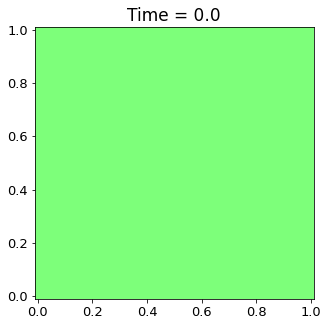

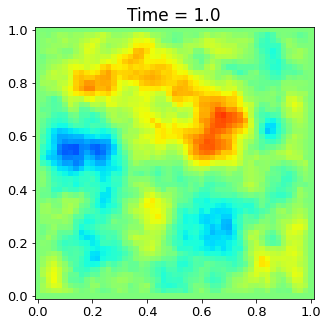

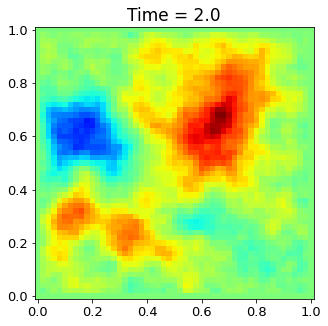

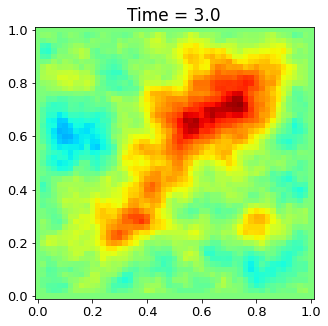

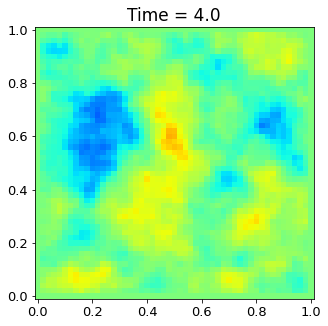

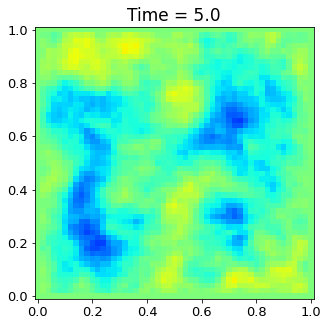

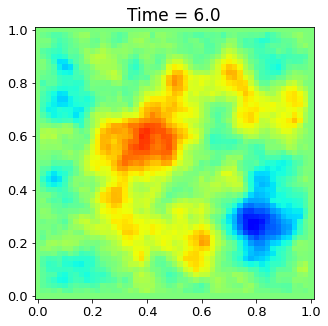

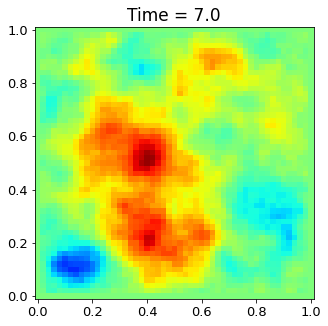

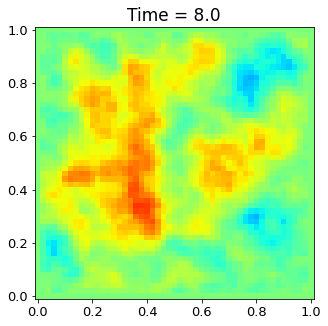

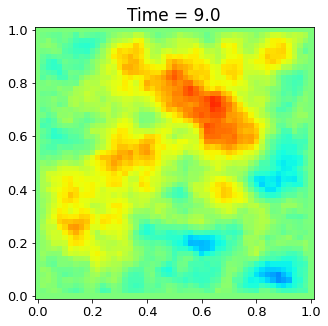

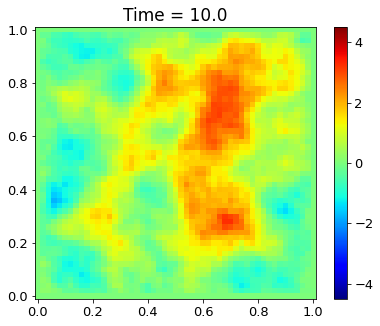

In [9]:
#Set desired resolutions
T = 10
gridN = 50
spaceN = 50
timeN = 50

#Simulate
np.random.seed(0)
X = simulateFractionalSPDEonRectangle(v_t = 1, v_s = 1, r_t = 5, r_s = 0.5, b_ = 0.5, sigma = 1, T = T, gridN = gridN, spaceN = spaceN, timeN = timeN, plotN = 10)

# Approximating the solution to the SPDE on a unit sphere

We now turn to simulations on the unit sphere. We first retransform the spherical harmonics given by scipy to their real counterparts: 

In [21]:
def real_spherical_harmonic(THETA, phi, l, m): 
    if m < 0 :
        return(sqrt(2) * (-1)**m * np.imag(scipy.special.sph_harm(abs(m), l, THETA, phi)))
    if m == 0:
        return(np.real(scipy.special.sph_harm(0, l, THETA, phi)))
    if m > 0:
        return(sqrt(2) * (-1)**m * np.real(scipy.special.sph_harm(m, l, THETA, phi)))

The following code simulates a solution to the SPDE on the unit square under the given parameters and outputs a series of plots of the simulated random field. <span style="color:blue">simulateFractionalSPDEonRectangle</span> takes as input the parameters $v_t$, $v_s$, $r_t$, $r_s$, $\beta_s$ and $\sigma$, a maximal time $T$, the plotting resolution <span style="color:red">gridN</span>, the (square-root of the) number of eigenfunctions <span style="color:red">spaceN</span>, the number of desired temporal nodes <span style="color:red">timeN</span>, and the number of plots to be draw <span style="color:red">plotN</span>.

In [22]:
def simulateFractionalSPDEonSphere(v_t, v_s, r_t, r_s, b_, sigma, T, gridN, spaceN, timeN, plotN = 0):
    
    radius = 1
    
    #Compute the parameters

    bb = (v_s) / (v_s + 1)
    
    ga = v_t * max(1, b_ / bb) + 0.5
    al = 0.5 * v_s/v_t * min(1, b_ / bb)
    be = (1 - b_) / bb * v_s   
    ka = sqrt(8 * v_s) / r_s
    r = r_t * ka**(2*al) / sqrt(8 * (ga - 0.5))

    print("-"*100)
    print("gamma =", ga, ", alpha =", al, ", beta =", be, ", r =", r, ", sigma =", sigma, ", kappa =", ka)
    print("-"*100)
    
    v_t = ga - 0.5 + 1/(2 * al) * min(be - 1, 0)
    v_s = be + al * (2*ga - 1) - 1
    
    print("Temporal smoothness:", v_t)
    print("Spatial smoothness:", v_s)

    r_t = sqrt(8 * (ga - 0.5)) * r / ka**(2*al)
    r_s = sqrt(8 * v_s) / ka

    print("(Approximate) temporal range: ", r_t)
    print("(Approximate) spatial range: ", r_s)
    
    print("-"*100)
    
    
    #Compute the eigenfunctions and eigenvalues of the operators A and Q for the unit square
    t = time.time()
    print("Calculating eigenvalues: ", end = "")

    keys = []
    XI = {}
    MU = {}
    LA = {}
    NORM = []
    
    for l in range(spaceN):
        for m in range(-l, l + 1):
            keys.append((l,m))
            XI[(l,m)] = l * (l + 1) / radius
            MU[(l,m)] = r**(-1) * (ka**2 + XI[(l,m)])**(al)
            LA[(l,m)] = sigma**2 * r**(-ga) * (ka**2 + XI[(l,m)])**(-be)
            NORM.append(LA[(l,m)] * MU[(l,m)]**(1 - 2 * ga))
    
    #normalize LA
    C = scipy.special.gamma(2 * ga - 1) / scipy.special.gamma(ga)**2 * 2**(1 - 2*ga) * sum(NORM)
    for k in keys: 
        LA[k] = LA[k] / C

    THETA = np.linspace(0, 2*pi, 2*gridN + 1)  
    PHI = np.linspace(0, pi, gridN + 1)
    
    print("Done! (", str(round(time.time() - t, 2)), "s. ) (", len(keys),"basis functions )")
    
    
    #Simulate the coefficients using the above methods
    t = time.time()
    print("Simulating coefficients: ", end = "")

    t_nodes = np.linspace(0, T, timeN + 1)

    method = simulateSpectralCoefficient_LinearProjection()
    COEF = simulateFractionalSPDECoefficients(keys, t_nodes, method, MU, LA, ga, silent = False)
    
    print("Done! (", str(round(time.time() - t, 2)), "s. )")
    
    
    #Compute the value of the SPDE at equidistant nodes on the unit square
    t = time.time()
    print("Interpolating onto grid:", end = "\r")
    
    X = np.zeros((gridN + 1, 2*gridN + 1, timeN + 1))
    n = 0
    for k in keys:
        
        #This prints a progess bar (this is the most time-consuming task)
        per = floor(100*n/len(keys))
        print("Interpolating onto grid: |"+"="*(per//2)+"-"*(50 - per//2 - 1)+"|"+" "+str(per)+"%", end='\r')
        
        n += 1
        for t_ in range(timeN + 1):
            for i in range(gridN + 1):
                X[i, :, t_] += COEF[k][t_] * real_spherical_harmonic(THETA, PHI[i], k[0], k[1])
  
    print("Interpolating onto grid: Done! (", str(round(time.time() - t, 2)), "s.)" + " "*60)
    t = time.time()
    
    
    #Plot the desired number of plots
    if plotN != 0:
        
        lim = np.max(np.abs(X))        
        THETA = np.linspace(-np.pi, np.pi, 2*gridN + 1)
        PHI = np.linspace(-np.pi/2., np.pi/2., gridN + 1)
        
        for i in range(plotN + 1):
            t = int(round(i / plotN * timeN))
            
            fig = plt.figure(figsize=(12,5))
            ax1 = plt.subplot(111, projection='mollweide')
            
            txt_title = ax1.set_title("Time = " + str(round(t / timeN * T, 2)))
            im = ax1.pcolormesh(THETA, PHI, X[:,:,t], cmap='jet', vmin = -lim, vmax = lim)

            if i==plotN: fig.colorbar(im, orientation='vertical');
    
            plt.show()

    return(X)

----------------------------------------------------------------------------------------------------
gamma = 1.5 , alpha = 0.5 , beta = 1.0 , r = 5.0 , sigma = 10 , kappa = 2.8284271247461903
----------------------------------------------------------------------------------------------------
Temporal smoothness: 1.0
Spatial smoothness: 1.0
(Approximate) temporal range:  5.0
(Approximate) spatial range:  1.0
----------------------------------------------------------------------------------------------------
Calculating eigenvalues: Done! ( 0.01 s. ) ( 1024 basis functions )
Simulating coefficients: Done! ( 4.57 s. )
Interpolating onto grid: Done! ( 399.85 s.)                                                            


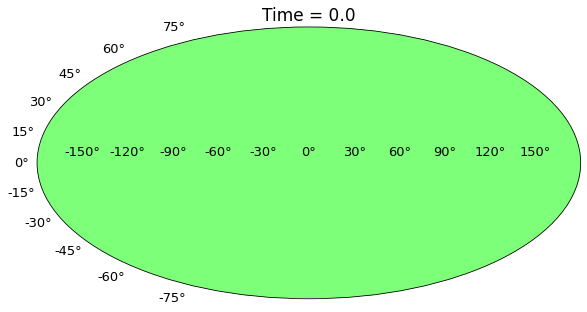

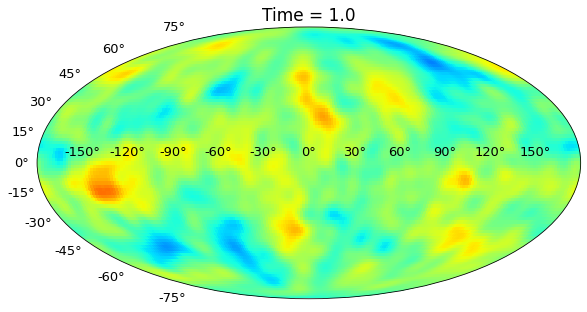

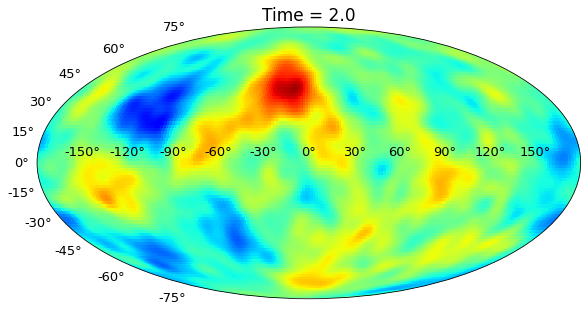

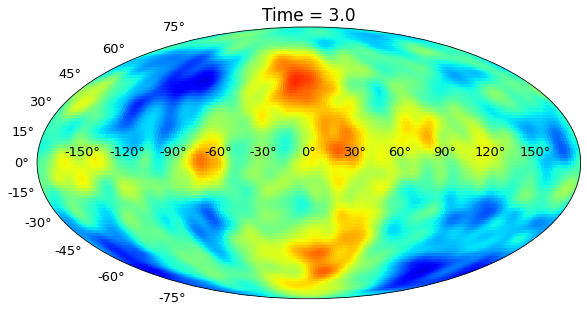

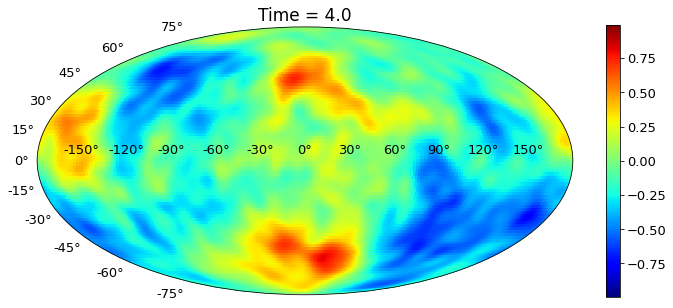

In [23]:
gridN = 100
spaceN = 32
timeN = 80
plotN = 4

np.random.seed(0)
X = simulateFractionalSPDEonSphere(v_t = 1, v_s = 1, r_t = 5.0, r_s = 1.0, b_ = 0.5, sigma = 10, T = 4, gridN = gridN, spaceN = spaceN, timeN = timeN, plotN = plotN)

The following code, like the code above, simulates a solution to the SPDE on the unit square under the given parameter, but instead only outputs plots of the equatorial trace at t = T, and the temporal trace at x = (0,0). <span style="color:blue">simulateFractionalSPDEonRectangle</span> takes as input the parameters $v_t$, $v_s$, $r_t$, $r_s$, $\beta_s$ and $\sigma$, a maximal time $T$, the (square-root of the) number of eigenfunctions <span style="color:red">spaceN</span>, the number of desired temporal nodes <span style="color:red">timeN</span>, and the plotting resolution on the equatorial trace <span style="color:red">plotN</span>.

In [13]:
def simulateFractionalSPDEtracesonSphere(v_t, v_s, r_t, r_s, b_, sigma, T, spaceN, timeN, plotN):
    
    radius = 1
    
    #Compute the parameters
    
    bb = (v_s) / (v_s + 1)
    
    ga = v_t * max(1, b_ / bb) + 0.5
    al = 0.5 * v_s/v_t * min(1, b_ / bb)
    be = (1 - b_) / bb * v_s   
    ka = sqrt(8 * v_s) / r_s
    r = r_t * ka**(2*al) / sqrt(8 * (ga - 0.5))

    print("-"*100)
    print("gamma =", ga, ", alpha =", al, ", beta =", be, ", r =", r, ", sigma =", sigma, ", kappa =", ka)
    print("-"*100)
    
    v_t = ga - 0.5 + 1/(2 * al) * min(be - 1, 0)
    v_s = be + al * (2*ga - 1) - 1
    
    print("Temporal smoothness:", v_t)
    print("Spatial smoothness:", v_s)

    r_t = sqrt(8 * (ga - 0.5)) * r / ka**(2*al)
    r_s = sqrt(8 * v_s) / ka

    print("(Approximate) temporal range: ", r_t)
    print("(Approximate) spatial range: ", r_s)
    
    print("-"*100)
    
    
    #Compute the eigenfunctions and eigenvalues of the operators A and Q for the unit square
    t = time.time()
    print("Calculating eigenvalues: ", end = "")

    keys = []
    XI = {}
    MU = {}
    LA = {}
    NORM = []
    
    for l in range(spaceN):
        for m in range(-l, l + 1):
            keys.append((l,m))
            XI[(l,m)] = l * (l + 1) / radius
            MU[(l,m)] = r**(-1) * (ka**2 + XI[(l,m)])**(al)
            LA[(l,m)] = sigma**2 * r**(-ga) * (ka**2 + XI[(l,m)])**(-be)
            NORM.append(LA[(l,m)] * MU[(l,m)]**(1 - 2 * ga))
    
    #normalize LA
    C = scipy.special.gamma(2 * ga - 1) / scipy.special.gamma(ga)**2 * 2**(1 - 2*ga) * sum(NORM)
    for k in keys: 
        LA[k] = LA[k] / C

    print("Done! (", str(round(time.time() - t, 2)), "s. ) (", len(keys),"basis functions )")
    
    
    #Simulate the coefficients using the above method
    t = time.time()
    print("Simulating coefficients: ", end = "")

    t_nodes = np.linspace(0, T, timeN + 1)

    method = simulateSpectralCoefficient_LinearProjection()
    COEF = simulateFractionalSPDECoefficients(keys, t_nodes, method, MU, LA, ga, silent = False)
    
    print("Done! (", str(round(time.time() - t, 2)), "s. )")
    
    
    #Compute the value of the SPDE at the desired traces
    t = time.time()
    
    temporal_trace = []
    for t in range(len(t_nodes)):
        temporal_trace.append(0)
        for k in keys:
            temporal_trace[t] += COEF[k][t] * real_spherical_harmonic(0, 0, k[0], k[1])
    
    spatial_trace = []
    s_nodes = np.linspace(0, 2*pi, plotN + 1)
    for s in range(len(s_nodes)):
        spatial_trace.append(0)
        for k in keys:
            spatial_trace[s] += COEF[k][timeN] * real_spherical_harmonic(s_nodes[s], pi/2, k[0], k[1])
            
    
    #Plot the traces
    plt.plot(t_nodes, temporal_trace, color = "green")
    plt.ylim((- 1, 1))
    plt.xlabel("Time")
    plt.ylabel("X(t,0)")
    plt.title("Temporal smoothness: " + str(round(v_t,2)))
    plt.show()

    plt.plot(s_nodes, spatial_trace, color = "red")
    plt.ylim((- 1, 1))
    plt.xlabel("Radians")
    plt.ylabel("X(T,s)")
    plt.title("Spatial smoothness: " + str(round(v_s,2)))
    plt.show()

----------------------------------------------------------------------------------------------------
gamma = 1.25 , alpha = 0.5 , beta = 0.75 , r = 0.8164965809277261 , sigma = 10 , kappa = 2.0
----------------------------------------------------------------------------------------------------
Temporal smoothness: 0.5
Spatial smoothness: 0.5
(Approximate) temporal range:  1.0
(Approximate) spatial range:  1.0
----------------------------------------------------------------------------------------------------
Calculating eigenvalues: Done! ( 0.01 s. ) ( 4096 basis functions )
Simulating coefficients: Done! ( 18.2 s. )


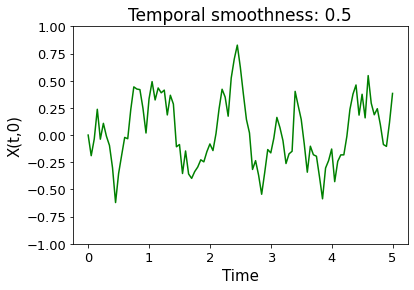

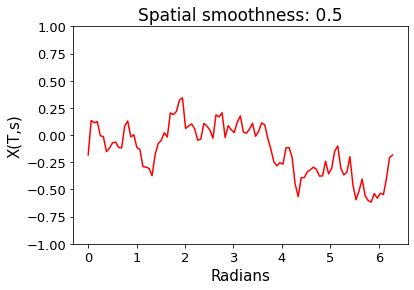

----------------------------------------------------------------------------------------------------
gamma = 2.75 , alpha = 0.16666666666666666 , beta = 0.75 , r = 0.29696623938011313 , sigma = 10 , kappa = 2.0
----------------------------------------------------------------------------------------------------
Temporal smoothness: 1.5
Spatial smoothness: 0.5
(Approximate) temporal range:  1.0
(Approximate) spatial range:  1.0
----------------------------------------------------------------------------------------------------
Calculating eigenvalues: Done! ( 0.01 s. ) ( 4096 basis functions )
Simulating coefficients: Done! ( 17.0 s. )


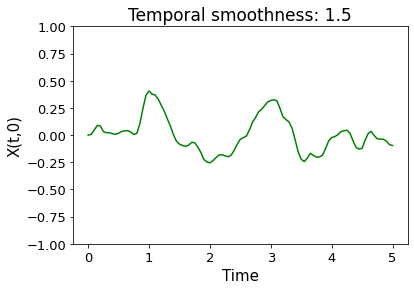

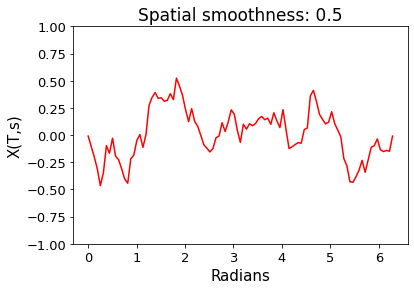

----------------------------------------------------------------------------------------------------
gamma = 1.0 , alpha = 1.25 , beta = 1.25 , r = 11.167258309225193 , sigma = 10 , kappa = 3.4641016151377544
----------------------------------------------------------------------------------------------------
Temporal smoothness: 0.5
Spatial smoothness: 1.5
(Approximate) temporal range:  1.0
(Approximate) spatial range:  1.0
----------------------------------------------------------------------------------------------------
Calculating eigenvalues: Done! ( 0.01 s. ) ( 4096 basis functions )
Simulating coefficients: Done! ( 19.25 s. )


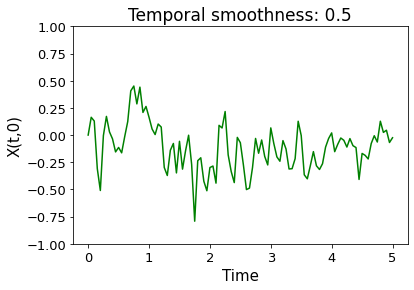

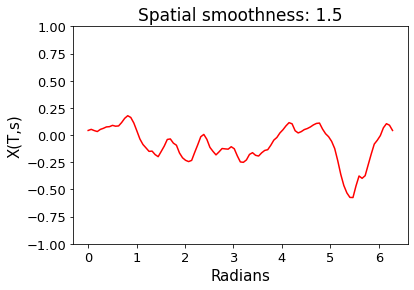

----------------------------------------------------------------------------------------------------
gamma = 2.0 , alpha = 0.4166666666666667 , beta = 1.25 , r = 0.8129582253002702 , sigma = 10 , kappa = 3.4641016151377544
----------------------------------------------------------------------------------------------------
Temporal smoothness: 1.5
Spatial smoothness: 1.5
(Approximate) temporal range:  1.0
(Approximate) spatial range:  1.0
----------------------------------------------------------------------------------------------------
Calculating eigenvalues: Done! ( 0.01 s. ) ( 4096 basis functions )
Simulating coefficients: Done! ( 18.13 s. )


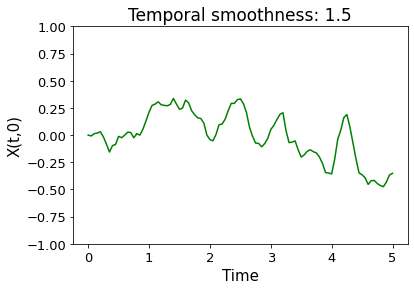

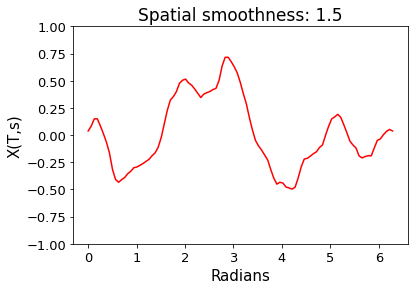

----------------------------------------------------------------------------------------------------
gamma = 4.25 , alpha = 0.1 , beta = 0.75 , r = 0.2097226669336511 , sigma = 10 , kappa = 2.0
----------------------------------------------------------------------------------------------------
Temporal smoothness: 2.5
Spatial smoothness: 0.5
(Approximate) temporal range:  1.0
(Approximate) spatial range:  1.0
----------------------------------------------------------------------------------------------------
Calculating eigenvalues: Done! ( 0.01 s. ) ( 4096 basis functions )
Simulating coefficients: Done! ( 18.72 s. )


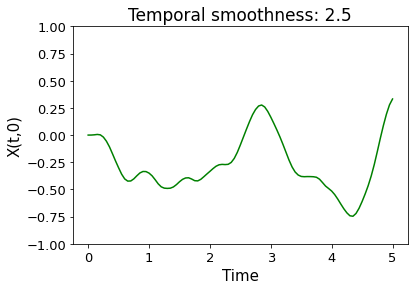

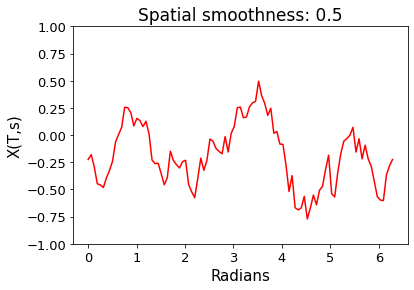

----------------------------------------------------------------------------------------------------
gamma = 3.0 , alpha = 0.25 , beta = 1.25 , r = 0.41617914502878167 , sigma = 10 , kappa = 3.4641016151377544
----------------------------------------------------------------------------------------------------
Temporal smoothness: 2.5
Spatial smoothness: 1.5
(Approximate) temporal range:  1.0
(Approximate) spatial range:  1.0
----------------------------------------------------------------------------------------------------
Calculating eigenvalues: Done! ( 0.01 s. ) ( 4096 basis functions )
Simulating coefficients: Done! ( 17.33 s. )


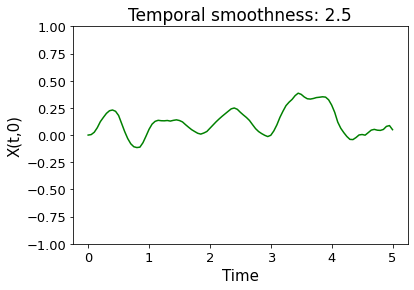

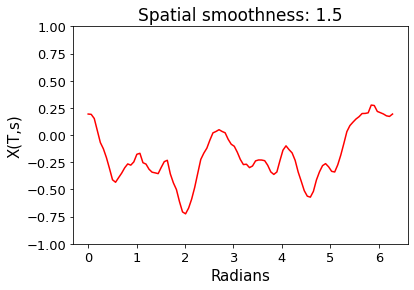

In [14]:
spaceN = 64
timeN = 100
plotN = 100

np.random.seed(1)
X = simulateFractionalSPDEtracesonSphere(v_t = 0.5, v_s = 0.5, r_t = 1, r_s = 1, b_ = 0.5, sigma = 10, T = 5, spaceN = spaceN, timeN = timeN, plotN = plotN)
X = simulateFractionalSPDEtracesonSphere(v_t = 1.5, v_s = 0.5, r_t = 1, r_s = 1, b_ = 0.5, sigma = 10, T = 5, spaceN = spaceN, timeN = timeN, plotN = plotN)

X = simulateFractionalSPDEtracesonSphere(v_t = 0.5, v_s = 1.5, r_t = 1, r_s = 1, b_ = 0.5, sigma = 10, T = 5, spaceN = spaceN, timeN = timeN, plotN = plotN)
X = simulateFractionalSPDEtracesonSphere(v_t = 1.5, v_s = 1.5, r_t = 1, r_s = 1, b_ = 0.5, sigma = 10, T = 5, spaceN = spaceN, timeN = timeN, plotN = plotN)

X = simulateFractionalSPDEtracesonSphere(v_t = 2.5, v_s = 0.5, r_t = 1, r_s = 1, b_ = 0.5, sigma = 10, T = 5, spaceN = spaceN, timeN = timeN, plotN = plotN)
X = simulateFractionalSPDEtracesonSphere(v_t = 2.5, v_s = 1.5, r_t = 1, r_s = 1, b_ = 0.5, sigma = 10, T = 5, spaceN = spaceN, timeN = timeN, plotN = plotN)



# Testing the temporal convergence order

We now want to test the temporal convergence order, i.e. the convergence order for each coefficient process using our methods. We use joblib to parallellize the computations.

In [15]:

# This function does k simulation of the coefficient with the same noise,
# but with different temporal resolutions
# It returns a list with the square of the reference solutio and the absolute errors
def func(r, repeats, k_list, l, ex, method, ga, mu, la):

    N = max(k_list) + ex
    
    #Simulate noise on a very fine noise
    nodes = np.linspace(0, l, 2**N + 1)
    W = simulateStochasticIntegralFunctionals(nodes, mu, method.order)
    
    #Compute the reference solution
    X_exact = method.method_2(len(nodes) - 1, nodes, mu, la, ga, W)

    #Contract the noise onto a courser grid
    for i in range(ex - 1):
        W,nodes = contractStochasticIntegralFunctionals(nodes, W, mu, method.order)

    #Store the square of the reference solution
    d_e_list = [X_exact**2]

    #Loop through all the desired grid resolutions
    for k in k_list[::-1]:

        #Contract the noise grid by one level
        W,nodes = contractStochasticIntegralFunctionals(nodes, W, mu, method.order)
        
        #Compute the approximate solution on a courser grid
        X_approx = method.method_2(len(nodes) - 1, nodes, mu, la, ga, W)

        #Store the error
        e = (X_approx - X_exact)**2
        d_e_list.append(e)

    return(d_e_list[::-1])


# This function performs a full error analysis for a given method
# It estimates the mean square relative error by repeated simulation and then approximates the 
# convergence order by linear regression across the errors.
# It also creates a convergence plot.
def errorAnalysis(k_list, l, repeats, ex, method, ga, mu, la):
    
    t = time.time()
    
    e_list = np.array([0 for k in k_list])
    
    print("-"*100)    
    print("Commencing calculations for gamma =", ga)
    print("Using lambda =", la, "and mu =", mu)
    
    #Using joblib to run the above function several times
    print("Starting calculation at : ", datetime.datetime.fromtimestamp(round(t)))
    d_e_list = Parallel(n_jobs=-1)(delayed(func)(r,repeats,k_list,l,ex,method,ga,mu,la) for r in range(repeats))
    print("Finished calculation at : ", datetime.datetime.fromtimestamp(round(time.time())))
 
    #Estimate the mean square relative error
    e_list = [sum(d_e_list[r][i] for r in range(repeats)) / sum(d_e_list[r][len(k_list)] for r in range(repeats)) for i in range(len(k_list))]
    e_list = [0.5*log(e,2) - 0.5*log(repeats,2) for e in e_list]
    
    #Report the time usage
    print("Total time taken for gamma = ", ga, ": ", round(time.time() - t,3), "s.")
    
    #Print the total list of errors
    print("-"*100)
    print("List of log-2 errors:", e_list)
    print("-"*100)
    
    #Perform linear regression
    regress = scipy.stats.linregress(k_list, e_list)
    slope_est = -regress[0]
    intercept_est = regress[1]
    slope_std = regress[4]
    
    #Print the estimated convergence order and the theoretical convergence order
    theoretical_order = min(ga - 0.5, method.order + 1)
    print("Theoretical convergence order: ", theoretical_order)
    print("Estimated order of convergence (regression): ", slope_est)
    print("Estimated order of convergence (last two): ", e_list[len(e_list) - 2] - e_list[len(e_list) - 1])
    
    #Print s.d. of the convergence order and 95% confidence interval
    #This is not that useful, but I have left it here anyway. The Monte-Carlo error is 
    #Gaussian, but there are other sources of error here that are not.
    print("Standard deviation of convergence order estimate: ", slope_std)
    print("95% confidence interval for the convergence order", [slope_est - 1.96*slope_std, slope_est + 1.96*slope_std])
    
    #Make convergence plot
    #if plot:
    #    plt.plot([-log(2,10) * k for k in k_list], [log(2,10) * e for e in e_list], "k*", label = "Observed error")
    #    x = np.linspace(-log(2,10) * min(k_list), - log(2,10) * max(k_list), 1000)
    #    plt.plot(x, [log(2,10)*intercept_est + slope_est * xx for xx in x], "b-", label = "Regression line")
    #    #plt.plot(x, [log(2,10) * e_list[len(e_list) - 1] + theoretical_order * (xx - x[len(x) - 1]) for xx in x], "r-", label = "Theoretical order: " + str(round(theoretical_order,2)))
    #    plt.plot(x, [log(2,10) * e_list[len(e_list) - 1] + theoretical_order * (xx - x[len(x) - 1]) for xx in x], "r-", label = "Theoretical order")
    #    plt.ylabel("Error")
    #    plt.xlabel("Step size")
    #    plt.ylim(y_lim)
    #    a = -log(2,10) * k_list[len(k_list) - 1]
    #    b = -log(2,10) * k_list[0]
    #    plt.xlim((a - (b-a)/8, b + (b - a)/4))
    #    plt.text(-log(2,10) * k_list[0] + (b-a)/18, log(2,10) * e_list[0], "γ=" + str(ga))
    #    #plt.legend()
    #    #plt.show()
        
    return(e_list)

We now test the left-point method.

In [16]:
np.random.seed(0)
method = simulateSpectralCoefficient_ConstantApprox(0)

#This gives a list of resolutions we are interested in testing
#k_list = [4,5,6,7,8,9,10,11,12,13,14,15,16]
k_list = [7,8,9,10]

#The gamma's that we are interested in testing
ga_list = [0.7,0.8,0.9, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9, 2.0]

#Approximate the rate for each of the gamma's
conv_rate_0 = []
e_0 = []
for ga in ga_list:
    mu = 1
    la = scipy.special.gamma(ga)**2 / scipy.special.gamma(2*ga - 1) * (2 * mu)**(2 * ga - 1)
    e_list = errorAnalysis(k_list, l = 1, repeats = 100, ex = 7, method = method, ga = ga, mu = mu, la = la)
    regress = scipy.stats.linregress(k_list, e_list)
    conv_rate_0.append(-regress[0])
    e_0.append(e_list)

----------------------------------------------------------------------------------------------------
Commencing calculations for gamma = 0.7
Using lambda = 1.002318230536272 and mu = 1
Starting calculation at :  2024-06-27 16:10:34
Finished calculation at :  2024-06-27 16:11:57
Total time taken for gamma =  0.7 :  82.983 s.
----------------------------------------------------------------------------------------------------
List of log-2 errors: [-5.289369458931911, -5.507195242487152, -5.730826676825203, -6.027126178322854]
----------------------------------------------------------------------------------------------------
Theoretical convergence order:  0.19999999999999996
Estimated order of convergence (regression):  0.2436901592510881
Estimated order of convergence (last two):  0.29629950149765083
Standard deviation of convergence order estimate:  0.01327802785850866
95% confidence interval for the convergence order [0.21766522464841115, 0.2697150938537651]
-------------------------

Finished calculation at :  2024-06-27 16:24:07
Total time taken for gamma =  1.8 :  77.643 s.
----------------------------------------------------------------------------------------------------
List of log-2 errors: [-9.927282285058752, -10.757358257114188, -11.785323501371984, -12.836450693757019]
----------------------------------------------------------------------------------------------------
Theoretical convergence order:  1
Estimated order of convergence (regression):  0.9755470470352599
Estimated order of convergence (last two):  1.0511271923850352
Standard deviation of convergence order estimate:  0.03707073291860365
95% confidence interval for the convergence order [0.9028884105147967, 1.048205683555723]
----------------------------------------------------------------------------------------------------
Commencing calculations for gamma = 1.9
Using lambda = 3.8425674952707896 and mu = 1
Starting calculation at :  2024-06-27 16:24:07
Finished calculation at :  2024-06-27 16:2

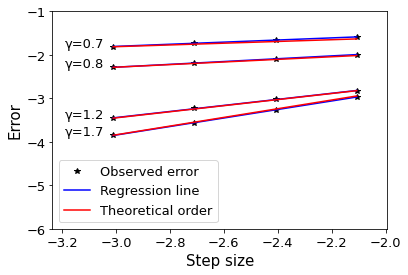

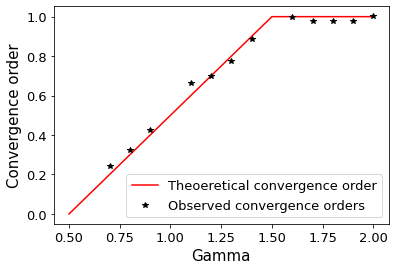

In [17]:
k_list = [7,8,9,10]
ga_list = [0.7, 0.8, 0.9, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9, 2.0]
p_list = [0.7, 0.8, 1.2, 1.7]

for ga in p_list:
    e_list = e_0[ga_list.index(ga)]
    y_lim = (-6,-1)
        
    #Perform linear regression
    regress = scipy.stats.linregress(k_list, e_list)
    slope_est = -regress[0]
    intercept_est = regress[1]
    theoretical_order = min(ga - 0.5, 1)
    
    plt.plot([-log(2,10) * k for k in k_list], [log(2,10) * e for e in e_list], "k*", label = "Observed error")
    x = np.linspace(-log(2,10) * min(k_list), - log(2,10) * max(k_list), 1000)
    plt.plot(x, [log(2,10)*intercept_est + slope_est * xx for xx in x], "b-", label = "Regression line")
    #plt.plot(x, [log(2,10) * e_list[len(e_list) - 1] + theoretical_order * (xx - x[len(x) - 1]) for xx in x], "r-", label = "Theoretical order: " + str(round(theoretical_order,2)))
    plt.plot(x, [log(2,10) * e_list[len(e_list) - 1] + theoretical_order * (xx - x[len(x) - 1]) for xx in x], "r-", label = "Theoretical order")
    plt.ylabel("Error")
    plt.xlabel("Step size")
    plt.ylim(y_lim)
    a = -log(2,10) * k_list[len(k_list) - 1]
    b = -log(2,10) * k_list[0]
    plt.xlim((a - (b-a)/4, b + (b - a)/8))
    n = len(k_list) - 1
    plt.text(-log(2,10) * k_list[n] - (b-a)/5, log(2,10) * e_list[n], "γ=" + str(ga))
    #plt.legend()
    #plt.show()
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

#Plot the approximated convergence rate against the gamma's
X = np.linspace(0.5,2,100)
plt.plot(X, [min(x - 0.5, 1) for x in X], "r-", label = "Theoeretical convergence order")
plt.plot(ga_list, conv_rate_0, "k*", label = "Observed convergence orders")
plt.xlabel("Gamma")
plt.ylabel("Convergence order")
plt.legend()
plt.show()

We now test the projection method.

In [18]:
np.random.seed(0)
method = simulateSpectralCoefficient_LinearProjection()

#This gives a list of resolutions we are interested in testing
k_list = [4,5,6,7]

#The gamma's that we are interested in testing
ga_list = [0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.7, 2.9, 3.1, 3.3]

#Approximate the rate for each of the gamma's
conv_rate_1 = []
e_1 = []
for ga in ga_list:
    mu = 0.1
    la = 1
    e_list = errorAnalysis(k_list, l = 1, repeats = 100, ex = 7, method = method, ga = ga, mu = mu, la = la)
    regress = scipy.stats.linregress(k_list, e_list)
    conv_rate_1.append(-regress[0])
    e_1.append(e_list)


----------------------------------------------------------------------------------------------------
Commencing calculations for gamma = 0.9
Using lambda = 1 and mu = 0.1
Starting calculation at :  2024-06-27 16:26:42
Finished calculation at :  2024-06-27 16:26:57
Total time taken for gamma =  0.9 :  14.147 s.
----------------------------------------------------------------------------------------------------
List of log-2 errors: [-8.824460409450168, -9.248134375747211, -9.73109770753787, -9.971445819063224]
----------------------------------------------------------------------------------------------------
Theoretical convergence order:  0.4
Estimated order of convergence (regression):  0.3923919560629825
Estimated order of convergence (last two):  0.2403481115253534
Standard deviation of convergence order estimate:  0.035999182215789356
95% confidence interval for the convergence order [0.32183355892003535, 0.46295035320592964]
-------------------------------------------------------

Finished calculation at :  2024-06-27 16:29:03
Total time taken for gamma =  2.9 :  14.116 s.
----------------------------------------------------------------------------------------------------
List of log-2 errors: [-13.728812723316398, -15.761767528619455, -17.766919107312, -19.804638531641316]
----------------------------------------------------------------------------------------------------
Theoretical convergence order:  2
Estimated order of convergence (regression):  2.02326290036673
Estimated order of convergence (last two):  2.0377194243293175
Standard deviation of convergence order estimate:  0.004334843905324456
95% confidence interval for the convergence order [2.014766606312294, 2.031759194421166]
----------------------------------------------------------------------------------------------------
Commencing calculations for gamma = 3.1
Using lambda = 1 and mu = 0.1
Starting calculation at :  2024-06-27 16:29:03
Finished calculation at :  2024-06-27 16:29:17
Total time tak

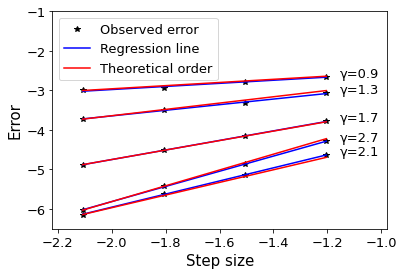

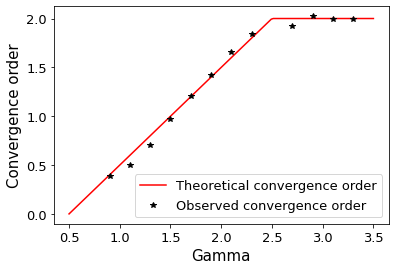

In [19]:
k_list = [4,5,6,7]
ga_list = [0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.7, 2.9, 3.1, 3.3]
p_list = [0.9, 1.3, 1.7, 2.1, 2.7]

for ga in p_list:
    e_list = e_1[ga_list.index(ga)]
    y_lim = (-6.5,-1)
        
    #Perform linear regression
    regress = scipy.stats.linregress(k_list, e_list)
    slope_est = -regress[0]
    intercept_est = regress[1]
    theoretical_order = min(ga - 0.5, 2)
    
    plt.plot([-log(2,10) * k for k in k_list], [log(2,10) * e for e in e_list], "k*", label = "Observed error")
    x = np.linspace(-log(2,10) * min(k_list), - log(2,10) * max(k_list), 1000)
    plt.plot(x, [log(2,10)*intercept_est + slope_est * xx for xx in x], "b-", label = "Regression line")
    #plt.plot(x, [log(2,10) * e_list[len(e_list) - 1] + theoretical_order * (xx - x[len(x) - 1]) for xx in x], "r-", label = "Theoretical order: " + str(round(theoretical_order,2)))
    plt.plot(x, [log(2,10) * e_list[len(e_list) - 1] + theoretical_order * (xx - x[len(x) - 1]) for xx in x], "r-", label = "Theoretical order")
    plt.ylabel("Error")
    plt.xlabel("Step size")
    plt.ylim(y_lim)
    a = -log(2,10) * k_list[len(k_list) - 1]
    b = -log(2,10) * k_list[0]
    plt.xlim((a - (b-a)/8, b + (b - a)/4))
    n = len(k_list) - 1
    plt.text(-log(2,10) * k_list[0] + (b-a)/18, log(2,10) * e_list[0], "γ=" + str(ga))
    #plt.legend()
    #plt.show()
    
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

#Plot the approximated convergence rate against the gamma's
X = np.linspace(0.5,3.5,150)
plt.plot(X, [min(x - 0.5, 2) for x in X], "r-", label = "Theoretical convergence order")
plt.plot(ga_list, conv_rate_1, "k*", label = "Observed convergence order")
plt.xlabel("Gamma")
plt.ylabel("Convergence order")
plt.legend()
plt.show()


# Testing the spectral convergence order

We now want to test the spectral convergence order. We do our test on the unit square using the projection method in time.

In [20]:
# This function performs an error analysis for the unit square using 
def spectralErrorAnalysisOnRectangle(v_t, v_s, r_t, r_s, b_, sigma, plot, T, spaceN, timeN):
    
    
    #Compute the parameters
    bb = (v_s) / (v_s + 1)
    
    ga = v_t * max(1, b_ / bb) + 0.5
    al = 0.5 * v_s/v_t * min(1, b_ / bb)
    be = (1 - b_) / bb * v_s   
    ka = sqrt(8 * v_s) / r_s
    r = r_t * ka**(2*al) / sqrt(8 * (ga - 0.5))

    print("-"*100)
    print("gamma =", ga, ", alpha =", al, ", beta =", be, ", r =", r, ", sigma =", sigma, ", kappa =", ka)
    print("-"*100)
    
    v_t = ga - 0.5 + 1/(2 * al) * min(be - 1, 0)
    v_s = be + al * (2*ga - 1) - 1
    
    print("Temporal smoothness:", v_t)
    print("Spatial smoothness:", v_s)

    r_t = sqrt(8 * (ga - 0.5)) * r / ka**(2*al)
    r_s = sqrt(8 * v_s) / ka

    print("(Approximate) temporal range: ", r_t)
    print("(Approximate) spatial range: ", r_s)
    
    print("-"*100)
    print("Commencing calculations at : ", datetime.datetime.fromtimestamp(round(time.time())))
    
    
    #Compute the eigenfunctions and eigenvalues of the operators A and Q for the unit square
    keys = []
    XI = {}
    MU = {}
    LA = {}
    NORM = []
    
    for n_ in range(spaceN):
        for m_ in range(spaceN):
            k = (n_,m_)
            keys.append(k)
            XI[k] = (n_**2 + m_**2)* pi**2
            MU[k] = r**(-1) * (ka**2 + XI[k])**(al)
            LA[k] = sigma**2 * r**(-ga) * (ka**2 + XI[k])**(-be)
            NORM.append(LA[k] * MU[k]**(1 - 2*ga))
            
    keys = sorted(keys, key = lambda k : XI[k])
          
    #normalize LA
    C = scipy.special.gamma(2 * ga - 1) / scipy.special.gamma(ga)**2 * 2**(1 - 2*ga) * sum(NORM)
    for k in keys: 
        LA[k] = LA[k] / C
    
    
    #Simulate all the spectral coefficients processes
    #This defines our reference solution
    t_nodes = np.linspace(0, T, timeN + 1)
    method = simulateSpectralCoefficient_LinearProjection()
    COEF = simulateFractionalSPDECoefficients(keys, t_nodes, method, MU, LA, ga, silent = False, allCoef = False)
  

    #Compute the L^2-norm of the reference solution
    square_norm = sum([COEF[k]**2 for k in keys])

    
    #Compute relative errors
    log_spaceN = int(2*log(spaceN, 2))
    m_lst = [2**m for m in range(4,log_spaceN)]
    e = [sqrt((square_norm - sum([COEF[k]**2 for k in keys[0:M]]))/square_norm) for M in m_lst]
    log_e = [log(x, 2) for x in e]
    x = [log(n, 2) for n in m_lst]
    
    print("Completed calculations at : ", datetime.datetime.fromtimestamp(round(time.time())))
    print("-"*100) 
    print("List of log-2 errors:", log_e)
    print("-"*100)
    
    
    #Perform linear regression across errors
    est_bound_lower = log_spaceN - 4 - 4
    est_bound_upper = log_spaceN - 1 - 4
    regress = scipy.stats.linregress(x[est_bound_lower:est_bound_upper], log_e[est_bound_lower:est_bound_upper])
    slope_est = -regress[0]
    intercept_est = regress[1]
    slope_std = regress[4]
    theoretical_order = v_s / 2
    print()
    print("Theoretical convergence order: ", theoretical_order)
    print("Estimated order of convergence (regression): ", slope_est)
    print("Standard deviation of convergence order estimate: ", slope_std)
    print("95% confidence interval for the convergence order", [slope_est - 1.96*slope_std, slope_est + 1.96*slope_std])
    
    
    #Make a convergence plot
    if plot:
        plt.plot([log(2,10) * xx for xx in x], [log(2,10) * e for e in log_e], "k*-", label = "Observed error")
        plt.xlim((log(2,10) * x[0] - 0.5, log(2,10) * x[len(x) - 1] + 1.0))
        plt.text(log(2,10) * x[len(x) - 1] + 0.2, log(2,10) * log_e[len(log_e) - 1], "ν=" + str(v_s))
        x = [log(n,10) for n in m_lst]
        x_upper = x[est_bound_lower:est_bound_upper]
        plt.plot(x_upper, [intercept_est * log(2,10) - slope_est * x for x in x_upper], "b-", label = "Regression line")
        #plt.plot(x_upper, [log(2,10) * log_e[len(log_e) - 2] - theoretical_order * (x - x_upper[len(x_upper) - 1]) for x in x_upper], "r-", label = "Theoretical order: " + str(round(theoretical_order,2)))
        plt.plot(x_upper, [log(2,10) * log_e[len(log_e) - 2] - theoretical_order * (x - x_upper[len(x_upper) - 1]) for x in x_upper], "r-", label = "Theoretical order")
        plt.xlabel("# of basis functions (log10)")
        plt.ylabel("Error")
        plt.ylim((-2.5,0.25))
    
        #plt.legend(loc=3)
        #plt.show()
    
    return(slope_est)
 
      

----------------------------------------------------------------------------------------------------
gamma = 1.5 , alpha = 0.5 , beta = 1.0 , r = 50.0 , sigma = 1 , kappa = 28.284271247461902
----------------------------------------------------------------------------------------------------
Temporal smoothness: 1.0
Spatial smoothness: 1.0
(Approximate) temporal range:  5.0
(Approximate) spatial range:  0.1
----------------------------------------------------------------------------------------------------
Commencing calculations at :  2024-06-27 16:29:32
Completed calculations at :  2024-06-27 16:29:49
----------------------------------------------------------------------------------------------------
List of log-2 errors: [-0.11767318560994261, -0.16492603547256313, -0.2973978161415951, -0.5250931647526892, -0.7964949750877772, -1.1789405546528107, -1.6834747220048512, -2.2040196949207527, -2.8073312497199843, -3.640963660571245]
------------------------------------------------------

Completed calculations at :  2024-06-27 16:31:36
----------------------------------------------------------------------------------------------------
List of log-2 errors: [-0.12744839571995675, -0.27923979522800596, -0.4777599421124732, -0.8719494062884585, -1.3805336233904133, -2.246869916002245, -3.220261694060813, -4.39373511447653, -5.603711039902328, -6.984183189768386]
----------------------------------------------------------------------------------------------------

Theoretical convergence order:  1.25
Estimated order of convergence (regression):  1.1917246729207576
Standard deviation of convergence order estimate:  0.010537365546843192
95% confidence interval for the convergence order [1.171071436448945, 1.2123779093925702]


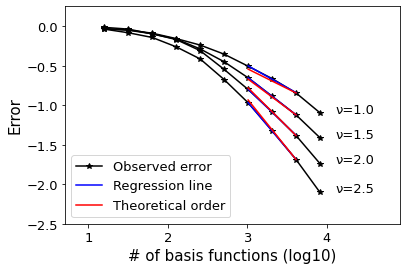

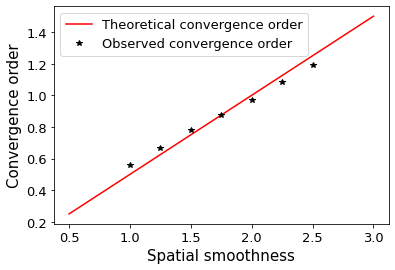

In [21]:
T = 1
spaceN = 2**7
timeN = 2**7

np.random.seed(0)

#Set parameters
v_t = 1
r_t = 5
r_s = 0.1
b_ = 0.5
sigma = 1

#Set lists of v_t's to test
v_s_list = [1.00, 1.25, 1.50, 1.75, 2.00, 2.25, 2.50]
p_list = [1.00, 1.50, 2.00, 2.50]

#Approximate the rate for each of the v_t's
conv_rate = []
for v_s in v_s_list:
    slope_est = spectralErrorAnalysisOnRectangle(v_t, v_s, r_t, r_s, b_, sigma, plot = (v_s in p_list), T = T, spaceN = spaceN, timeN = timeN)
    conv_rate.append(slope_est)
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=3)
plt.show()

#Plot the approximated convergence rate against the gamma's
X = np.linspace(0.50, 3.00, 100)
plt.plot(X, [x / 2 for x in X], "r-", label = "Theoretical convergence order")
plt.plot(v_s_list, conv_rate, "k*", label = "Observed convergence order")
plt.xlabel("Spatial smoothness")
plt.ylabel("Convergence order")
plt.legend()
plt.show()